# Formalia:
Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment.

If you fail to follow these simple instructions, it will negatively impact your grade!

Due date and time: The assignment is due on Tuesday November 1st, 2022 at 23:55. Hand in your IPython notebook file (with extension .ipynb) via http://peergrade.io/ (we won't be doing peergrading, but we'll still use http://peergrade.io/ for the handin.)

----

# Assignment 2: Network Science

_Course: 02805 - **Social Graphs and Interactions**_ <br>
_Course responsible: **Sune Lehmann Jørgensen**_ <br>
_DTU - **Technical University of Denmark**_  
_Due date - **01/11/2022**_ <br>
_Students - **Nikos Karageorgos, John Manganas, Georgios Panagiotopoulos**_

---

## Table of Contents:
- [__Part 0: Data__](#0.)

- [__Part 1: Basic Stats__](#1.)

- [__Part 2: Communities__](#2.)

- [__Part 3: Sentiment__](#3.)

---

Installation and Importing of all the necessary libraries we will need

In [67]:
%%capture
!pip install wordcloud
!pip install powerlaw!pip install fa2
from io import BytesIO
import requests
from scipy import stats as st
import collections
import powerlaw
from itertools import count
from fa2 import ForceAtlas2
from wordcloud import WordCloud, STOPWORDS
from nltk import *
import pprint
from nltk import word_tokenize
#nltk.download('punkt')
import pandas as pd
from sqlalchemy import create_engine
import string
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
import pickle
import numpy as np
import community.community_louvain as community_louvain

Our DC and Marvel superhero dataset after the proper extraction have been stored in a cloud PostgreSQL Database, easily and quickly accessible.

In [2]:
# Defining function for importing data from the cloud DB. The function returns two dataframes, one for each universe with two columns character_name, wiki_text
def DataImport(table_name):
  host="ec2-54-75-184-144.eu-west-1.compute.amazonaws.com"
  port="5432" 
  dbname="dab1kopm5t3l06"
  user="kpervzhazofybh" 
  password="0d1b5470c51c481880eed267865a8529bdc671f8cb90702d6dcb9e7c199d02ee"

  Engine   = create_engine('postgresql+psycopg2://{}:{}@{}:{}/{}'.format(user,password,host,port,dbname))

  # Connect to PostgreSQL server
  dbConnection = Engine.connect();

  # Read data from PostgreSQL database table and load into a DataFrame instance
  df = pd.read_sql("select * from {}".format(table_name), dbConnection)
  pd.set_option('display.expand_frame_repr', False)

  return df

In [45]:
# Our Network has been stored as a pickle file in our GitHub Repository of this second assignment
mLink = 'https://github.com/gpanagioto/projects_socialgraphs22/blob/main/Assignment2/SuperHeroesGraph.gpickle?raw=true'
mfile = BytesIO(requests.get(mLink).content)
G_Directed = pickle.load(mfile)

#G_dir = pickle.load(open('/content/drive/MyDrive/DTU/02805 Social graphs and interactions/SuperHeroesGraph.gpickle', 'rb'))

<a id='0.'></a>
# Part 0: Data 


In [46]:
##the directed graph to undirected
G_Undirected = G_Directed.to_undirected()

In [53]:
## Extract largest component 
LComp = sorted(nx.weakly_connected_components(G_Directed), key=len, reverse=True)

# Extract the largest connected graph and convert it to undirected
GCC = G_Directed.subgraph(LComp[0]).copy()
GCC_Undirected = GCC.to_undirected()


<a id='1.'></a>
# Part 1: Basic Stats 


* Write a short paragraph describing the network. The paragraph should contain the following information

  * The number of nodes and links. 🟢
  * The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees. 🟢

In [34]:
def Measures(graph, TypeOfDegree, Data):

  if TypeOfDegree == 'In':
    values = list(dict(graph.in_degree(Data)).values())
  else:
    values = list(dict(graph.out_degree(Data)).values())
  
  mean = np.mean(values)
  print("The average value is {}.".format(mean))
  median = np.median(values)
  print("\nThe median is {}.".format(median))
  mode = st.mode(values)
  print("\nThe mode is {}.".format(list(mode)[0][0]))
  min = np.min(values)
  print("\nThe min is {}.".format(min))
  max = np.max(values)
  print("\nThe max is {}.".format(max))

  return mean, median, list(mode)[0][0], min, max

In [54]:
print('The number of nodes of the network are {}. The number of edges of the network are {}.'.format(GCC.number_of_nodes(),GCC.number_of_edges()))

The number of nodes of the network are 2538. The number of edges of the network are 29998.


In [51]:
Data = list(GCC.nodes())
TypeOfDegree = 'In'
average, median, mode, min, max = Measures(GCC, TypeOfDegree, Data)

The average value is 11.837016574585636.

The median is 4.0.

The mode is 1.

The min is 0.

The max is 448.


In [52]:
Data = list(GCC.nodes())
TypeOfDegree = 'Out'
average, median, mode, min, max = Measures(GCC, TypeOfDegree, Data)

The average value is 11.837016574585636.

The median is 7.0.

The mode is 0.

The min is 0.

The max is 112.


* We also want the degree distributions and a plot of the network

  * Create in- and out-going degree distributions as described in Lecture 5. 🟢
  * Estimate the slope of the incoming degree distribtion as described in Lecture 5. 🟢
  * Plot the network using the Force Atlas algorithm as described in Lecture 5. 


Text(0.5, 1.0, 'Loglog plot for out-degree distribution')

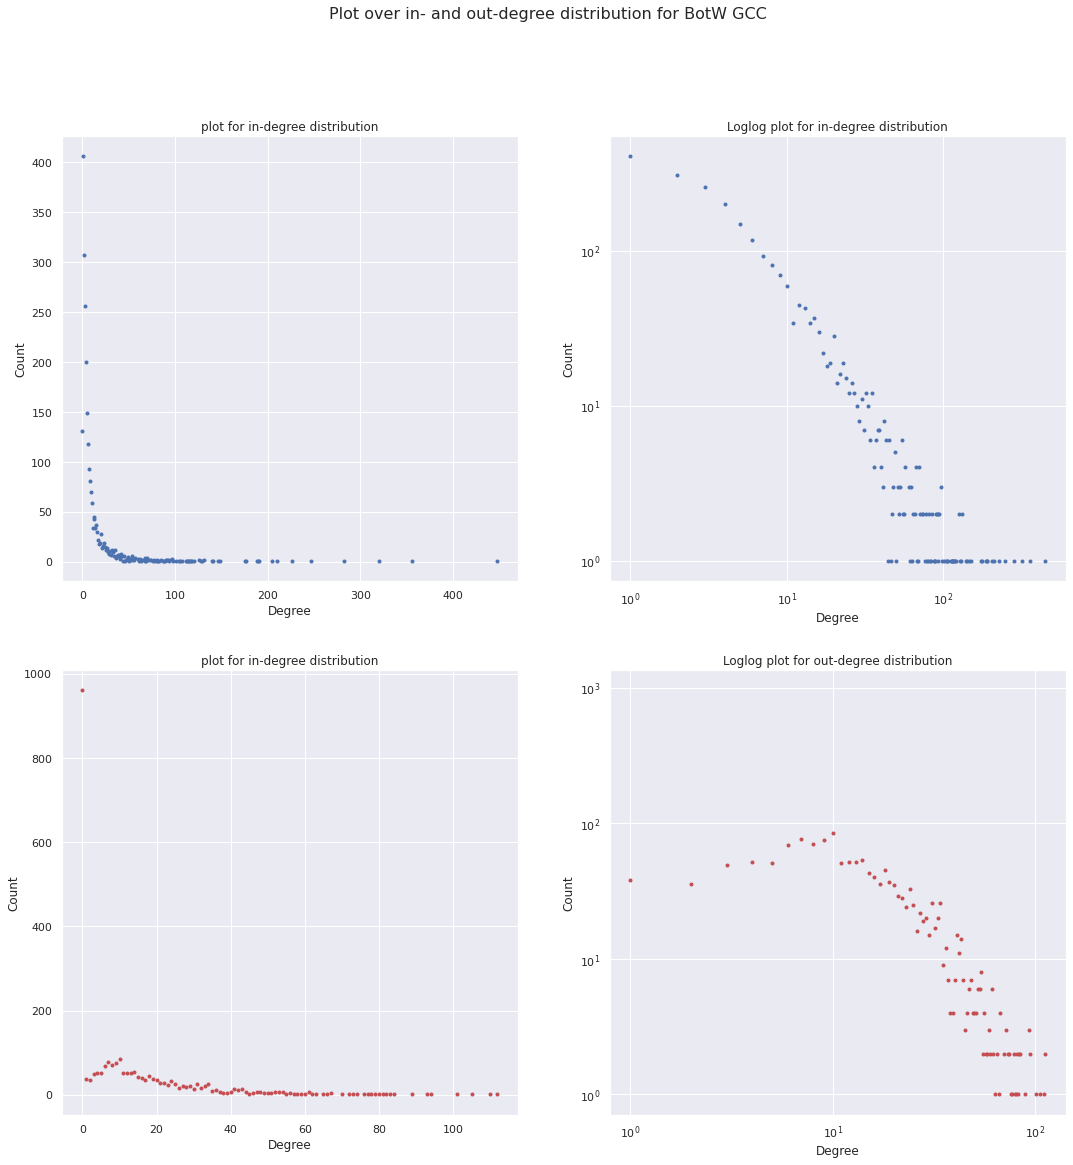

In [56]:
sns.set()
#The distribution of in-degree
degree_sequence_in = sorted([d for _, d in GCC.in_degree()])  # degree sequence
degreeCount_in = collections.Counter(degree_sequence_in)
deg_in, cnt_in = zip(*degreeCount_in.items())

#The distribution of out-degree
degree_sequence_out = sorted([d for _, d in GCC.out_degree()])  # degree sequence
degreeCount_out = collections.Counter(degree_sequence_out)
deg_out, cnt_out = zip(*degreeCount_out.items())

plt.figure(figsize = [18, 18])
plt.suptitle("Plot over in- and out-degree distribution for BotW GCC", fontsize=16)

#Plot in-degree
subax1 = plt.subplot(221)
plt.plot(deg_in, cnt_in, '.')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('plot for in-degree distribution')
subax2 = plt.subplot(222)
plt.loglog(deg_in, cnt_in, '.')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Loglog plot for in-degree distribution')

#Plot out-degree
subax1 = plt.subplot(223)
plt.plot(deg_out, cnt_out, '.r')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('plot for in-degree distribution')
subax2 = plt.subplot(224)
plt.loglog(deg_out, cnt_out, '.r')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Loglog plot for out-degree distribution')

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
2.52
Calculating best minimal value for power law fit


Text(0.5, 1.0, 'Loglog plot for in-degree distribution')

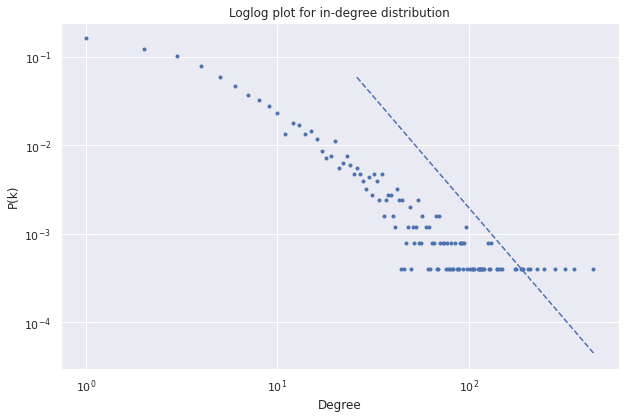

In [57]:
print(f'{powerlaw.Fit(degree_sequence_in, suppress_output=True).alpha:.2f}')

# plot for in_degree
plt.figure(figsize = [10, 14])
subax1 = plt.subplot(211)
temp = sum(np.array(list(cnt_in)))
plt.loglog(deg_in, np.array(list(cnt_in))/temp, '.')
fit = powerlaw.Fit(degree_sequence_in, suppress_output=True)
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit pdf')
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.title('Loglog plot for in-degree distribution')

In [64]:
def AttributesLinksColors(attrubutes_list, attr, network):

  AttrObject = nx.get_node_attributes(network, 'universe')

  d = []

  for node in network.nodes():
    for edge in list(network.edges([node])):
      if (AttrObject[edge[0]] != AttrObject[edge[1]]) and (AttrObject[edge[0]] == attrubutes_list[0]):
        d.append('teal')
      elif AttrObject[edge[0]] != AttrObject[edge[1]] and (AttrObject[edge[0]] == attrubutes_list[1]):
        d.append('darkorange')
      else:
        d.append('violet')

  return d

In [68]:
groups = set(nx.get_node_attributes(GCC_Undirected,'universe').values())
mapping = dict(zip(sorted(groups),count()))
nodes = GCC_Undirected.nodes()
node_colors = [mapping[GCC_Undirected.nodes[n]['universe']] for n in nodes]
edge_colors = AttributesLinksColors(['MARVEL','DC'],'universe',GCC_Undirected)

100%|██████████| 2000/2000 [01:31<00:00, 21.89it/s]


BarnesHut Approximation  took  35.60  seconds
Repulsion forces  took  48.77  seconds
Gravitational forces  took  0.25  seconds
Attraction forces  took  2.78  seconds
AdjustSpeedAndApplyForces step  took  1.10  seconds


Text(0.5, 1.0, 'Super Heroes network of characters using Force-Atlas node coordinates and degree as size')

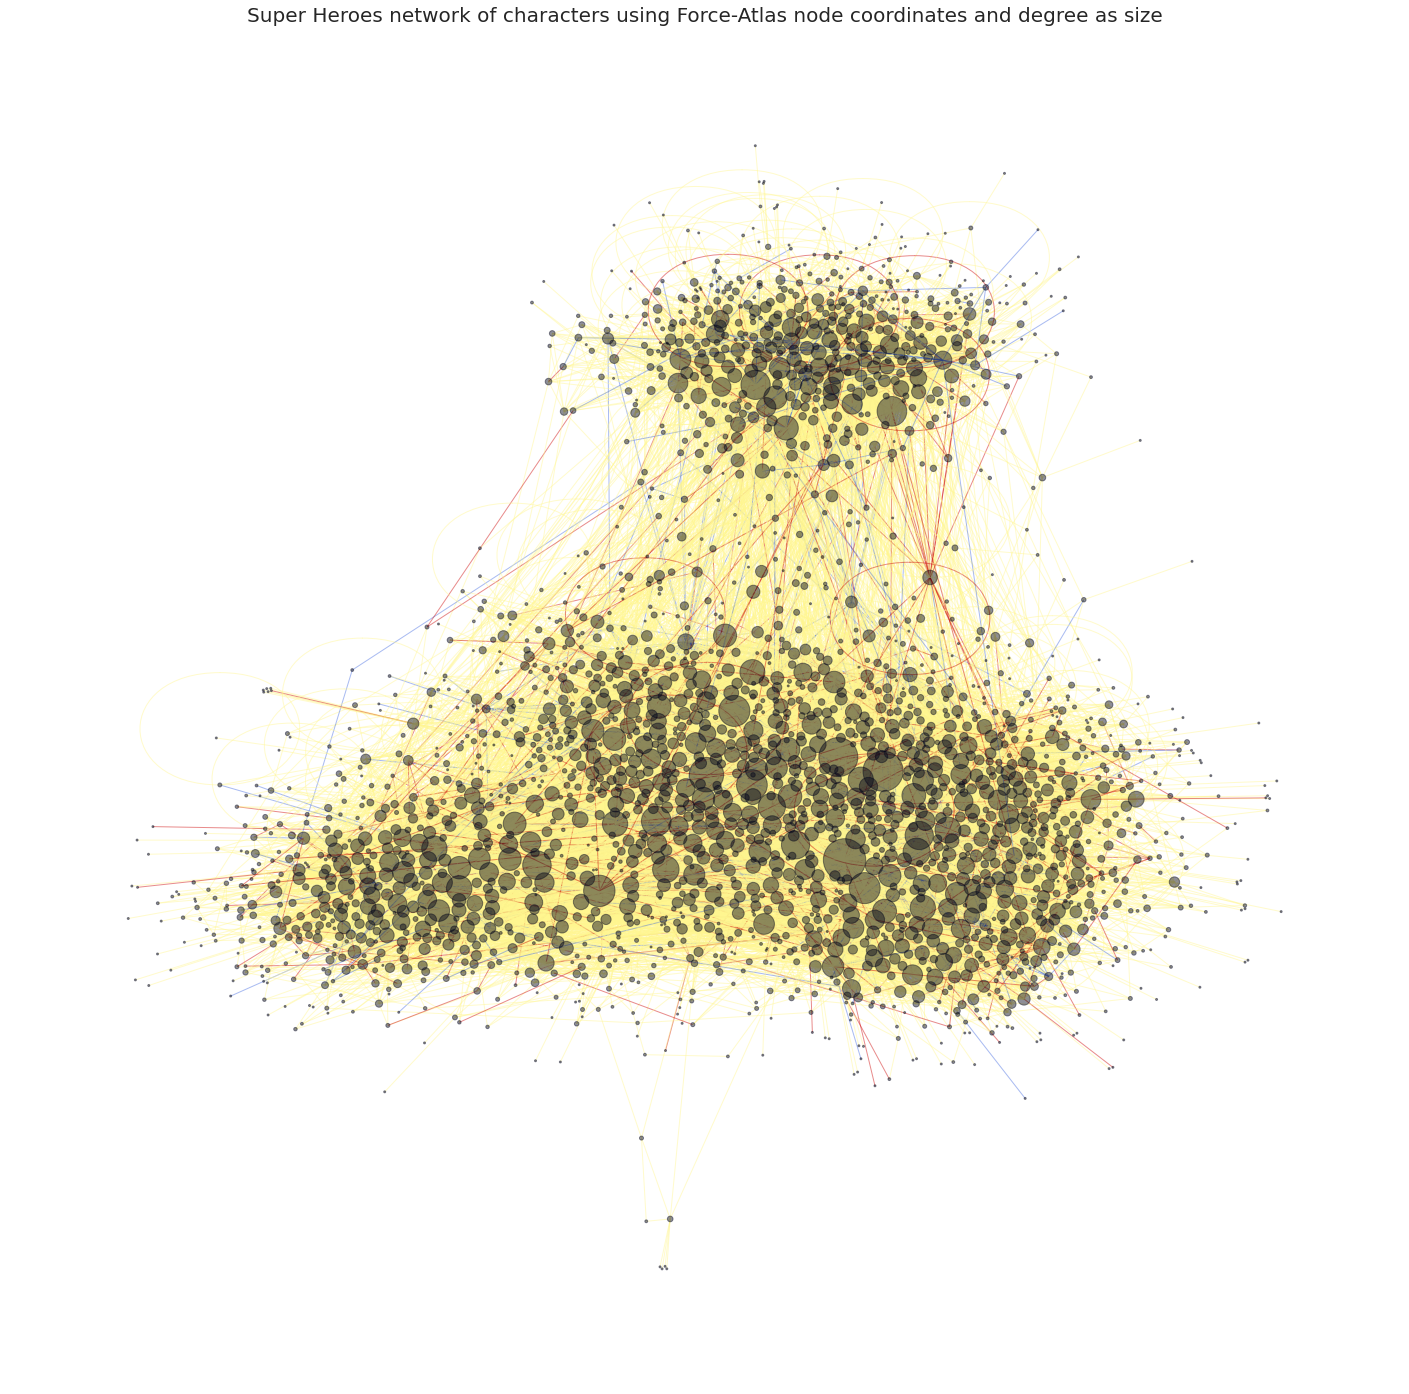

In [75]:
plt.figure(figsize=(25,25))
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.5,
                        strongGravityMode=False,
                        gravity=-0.5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GCC_Undirected, pos=None, iterations=2000)
nx.draw_networkx_nodes(GCC_Undirected, positions, node_size=[val*4 for (_, val) in GCC_Undirected.degree()], node_color=node_colors, alpha=0.45)
nx.draw_networkx_edges(GCC_Undirected, positions, edge_color=edge_colors, alpha=0.45, arrows=False)
plt.axis('off')
plt.title("Super Heroes network of characters using Force-Atlas node coordinates and degree as size", fontsize=20)

<a id='2.'></a>
# Communities

* Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.


In [78]:
marvel_community = G_Undirected.subgraph([n for n,v in G_Undirected.nodes(data=True) if v['universe'] == 'MARVEL'])  
dc_community = G_Undirected.subgraph([n for n,v in G_Undirected.nodes(data=True) if v['universe'] == 'DC'])

In [79]:
def Modularity(partitions, graph):
  return np.sum([partition.number_of_edges()/graph.number_of_edges() - (np.sum(list(dict(partition.degree()).values()))/(2*graph.number_of_edges()))**2 for partition in partitions])

In [83]:
Modularity([marvel_community,dc_community], G_Undirected)

0.31359690790048345

In [80]:
def Partitioning(community):

  partitions = community_louvain.best_partition(community)
  communities = set(partitions.values())
  modularity = community_louvain.modularity(partitions, community)

  return len(communities), modularity

In [81]:
print('The Marvel community counts {} subcommunities and the modularity is {:.2%}'.format(Partitioning(marvel_community)[0],Partitioning(marvel_community)[1]))
print('The DC community counts {} subcommunities and the modularity is {:.2%}'.format(Partitioning(dc_community)[0],Partitioning(dc_community)[1]))

The Marvel community counts 32 subcommunities and the modularity is 39.00%
The DC community counts 25 subcommunities and the modularity is 31.37%


* Visualize the communities as colors on the graph - also as described in Week 7

* Write a paragraph about your work to identify the communities. The paragraph should include

  * Information about the algorithm you used to find communities.
  * The value of modularity for your network.
  * The number of communities and their sizes (in terms of number of nodes).


* For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

* Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.